# Chapter 3: Robust Estimates for Expected Returns

## Key Concepts

- Understand lack of robustness of expected return estimates
- Analyse agnostic priors on expected returns
- Using factor models for estimating expected returns
- Extracting implied neutral expected return estimates
- Introducing active views
- Understand Black-Litterman model



The **main challenge** in portfolio construction is the **estimation of expected returns**.

We discuss in this module how **factor models can be used for more robust expected return estimate**. We also explain how to **link expected return estimates to risk parameter estimates**, and **introduce Bayesian techniques** and **statistical shrinkage** towards the grand mean for expected return estimation.

In a second step, we explain how to **incorporating active views in a Bayesian framework**. In particular, we introduce the **Black-Litterman model** as a relevant portfolio optimization method in the presence of parameter uncertainty, and we show how to apply **Bayesian analysis to combine historical estimates and non-sample views of varying reliability**.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2
%matplotlib inline

# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-pastel") 

## Estimates for expected returns

The **Modern Portfolio Theory** is not very useful because the estimation of the covariance matrix and the return vector is very difficult, especially the return vector because **very small changes in the expected returns normally result in large changes in output weights**. 

In general, **sample based information** such as the returns computed using sampled past data **are close to useless**. 

Let $N$ be the number of assets in our portfolio.

#### Shrinked expected returns 

A very basic estimate for expected returns is a simple modificiation of sample means. Let 
$$
\mu_i := \frac{1}{T} \sum_{t=1}^{T} r_{t}^{i} 
\quad\text{and}\quad
\bar{\mu} := \frac{1}{N} \sum_{i=1}^N \mu_i, 
$$
be the **sample mean return** of each asset 
and the **grand sample mean** (i.e., the mean of the computed mean returns), respectively. 
The sample mean might be improved by **shrinking** the individual means to the grand sample mean:
$$
\hat{\mu}_i := \delta \bar{\mu} + (1-\delta)\mu_i,
$$
given a shrinking factor $\delta\in [0,1]$

In [2]:
# these are the \mu_i
asset_means_rets = np.array([11.1, 12.3, 8.4, 15.3, 5.6, 9.7])/100

# this is \bar{\mu} 
grand_sample_mean = asset_means_rets.mean()

# shrinked mean
delta = 0.5
shrinked_mean_ret = delta * grand_sample_mean + (1-delta)* asset_means_rets

print("sample means:   {}%" .format( np.round(asset_means_rets*100,2)) )
print("shrinked means: {}%" .format( np.round(shrinked_mean_ret*100,2) ) )

sample means:   [11.1 12.3  8.4 15.3  5.6  9.7]%
shrinked means: [10.75 11.35  9.4  12.85  8.   10.05]%


### Relying on agnostic priors

Recall that the **expected return and the volatility of a portfolio** of $N$ assets are given by:
$$
\mu_p := \mathbf{w}^T\mathbf{\mu} = \sum_{i=1}^N w_i \mu_i
\quad\text{and}\quad
\sigma_p = (\mathbf{w}^T \Sigma \mathbf{w})^{1/2}, 
$$
where $\mathbf{w}:=(w_1,\dots,w_N)^T$ is the vector of weigths, 
$\mathbf{\mu}:=(\mu_1,\dots,\mu_N)$, where $\mu_i=\mathbb{E}[r_i]$ for each $i=1,\dots,N$ is the expected return of asset $i$, and $\Sigma$ is the expected covariance matrix of the assets.

The vector of expected returns $\mathbf{\mu}:=(\mu_1,\dots,\mu_N)$ is what we are mainly concerned about. 

We have to introduce some, ideally **economically motivated, priors**.


Let us suppose that we are interested in the maximum sharpe ratio portfolio, i.e., the portoflio or which the sharpe ratio:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \frac{ \sum_{i=1}^N w_i (\mu_i - r_f)}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} },
$$
is maximum.

#### 1. First agnostic prior: all returns are equal
Assume that **all expected returns are going to be equal**, for example, equal to the grand sample mean, 
in this case we have:
$$
\mu_i - r_f = \hat{\mu} - r_f \qquad \forall\; i,
$$
hence maximizing the sharpe ratio means is equivalent to minimizing the volatility:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \frac{ \sum_{i=1}^N w_i (\hat{\mu} - r_f)}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
= \frac{ \hat{\mu} - r_f }{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }.
$$

#### 2. Second agnostic prior: sharpe ratios are all equal
Assume that sharpe ratios are all equal, this means assuming that the excess return $\mu_i-r_f$ of each asset is proportional to the corresponding volatility $\sigma_i$:
$$
\mu_i - r_f = \lambda \sigma_i 
\qquad  \forall\; i, 
$$
where the constant of proportionality $\lambda$ is sharpe ratio supposed to be the same for each asset. The sharpe ratio of the portfolio becomes:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \frac{ \sum_{i=1}^N w_i \lambda \sigma_i}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
= \lambda \frac{ \sum_{i=1}^N w_i \sigma_i }{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }. 
$$
The ratio between the weigthed volatilities and the volatility of the portfolio is known as the **diversification ratio**.

It is a very strong assumption and we have reasons to believe that not all of risk is rewarded. 
In fact, asset pricing theory suggests that **only the systematic component is rewarded** and that 
the specific risk is not rewarded because it can be diversified away. In other words, asset pricing theory suggests that **we should not be rewarded for a piece of risks that we could have diversified away** and we should instead assume that **there is a relationship between excess expected return and (only) the systematic part of volatility**. 

Therefore, we want to **decompose volatility in terms of specific risk and systematic risk**, 
and come up with a better **estimate for expected returns by relating it to systematic risk**. 

We could do this using a **factor model**.

#### 3. Using a factor model to estimate (excess) returns

The simplest factor model that we can use is the **CAPM**. Recall that in the CAPM the expected escess return of an asset was proportional to the excess return of the market:
$$
\mu_i - r_f = \beta_i(\mu_m -r_f)
\qquad \forall \; i,
$$
where $\beta_i$ is the constant of proportionality. This is equivalent to impose that the following ratio:
$$
\text{TR}_i := \frac{\mu_i - r_f}{\beta_i} = \mu_m -r_f,
\qquad \forall \; i
$$
called the **Treynor ratio** is the same for all stocks and equal to the excess return of the market $\mu_m -r_f$. If we accept this model, then the maximum sharpe ratio portfolio would has a sharpe ratio equal to:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p}
= \frac{ \sum_{i=1}^N w_i (\mu_i - r_f)}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
= (\mu_m - r_f) \frac{ \sum_{i=1}^N w_i \beta_i}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }, 
$$
where the numerator is the $\beta$ of the portfolio, that is, the weigthed average of $\beta_i$. 

Below, we consider the $30$ industry portfolios and compare the annualized returns obtained simply using the historical data and using the CAMP model:

In [3]:
# Load data
nind = 30
start = "2013"
ind_rets = erk.get_ind_returns(n_inds= nind)[start:]
fff = erk.get_fff_returns()[start:]
mkt_excess_rets = fff[["Mkt-RF"]]

In [4]:
# compute the excess returns of all industries
rf = pd.DataFrame().reindex_like(ind_rets)
for col in rf.columns:
    rf[col] = fff["RF"].values
ind_exc_rets = ind_rets - rf 
# compute the annualized "historic" mean return
historic_mean = erk.annualize_rets( ind_exc_rets, periods_per_year=12 )
historic_mean.head()

Food     0.081512
Beer     0.121787
Smoke    0.068340
Games    0.172070
Books    0.022859
dtype: float64

In [5]:
# computing beta for each industry  
industries = ind_rets.columns
betas = []
for industry in industries:
    ind_excess_rets = ind_rets[industry] - fff["RF"].values
    lm = erk.regress(ind_excess_rets, mkt_excess_rets)
    betas.append( lm.params[0] )
betas = pd.DataFrame(betas, index=ind_rets.columns, columns=["Mkt-RF"])
# now estimate excess returns of the industries using the CAPM model: beta * exc_ret_of_the_market
capm_rets = []
for industry in betas.index:
    capm_rets.append( erk.annualize_rets( betas.loc[industry] * mkt_excess_rets , periods_per_year=12 )[0] )
capm_rets = pd.Series(capm_rets, index=betas.index)
capm_rets.head()

Food     0.076901
Beer     0.068366
Smoke    0.063972
Games    0.145194
Books    0.151793
dtype: float64

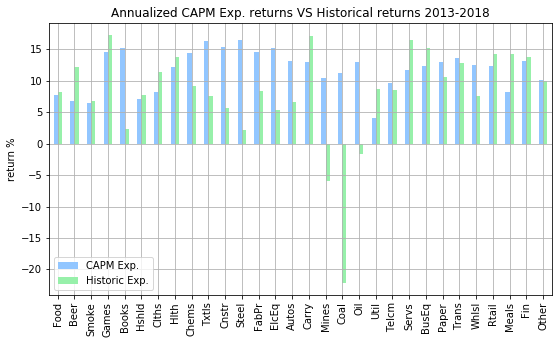

In [6]:
A = pd.concat([capm_rets, historic_mean], axis=1) * 100
A.columns = ["CAPM Exp.","Historic Exp."]
ax = A.plot.bar(grid=True, figsize=(9,5), title="Annualized CAPM Exp. returns VS Historical returns {}-2018".format(start))
ax.set_ylabel("return %")
plt.show()

Observe that the CAPM expected returns are all positives and are contained in a much smaller range of returns. 

## Black-Litterman model

### Background and Theory

The **Black-Litterman model** provides a methodical way of **combining an investors subjective views** of the future performance of a risky investment asset with the **views implied by the market equilibrium**. 

The procedure can be viewed as a **bayesian shrinkage method that shrinks the expected returns constructed from an investor's views on asset returns towards asset returns implied by the market equilibrium**:
1. Computes a set of expected returns (**implied returns**) that uses the **market equilibrium implied as a prior**
2. Combined with returns implied by subjective investor views to produce a set of posterior expected returns $\mu^{BL}$ and covariances $\Sigma^{BL}$.

**When $\mu^{BL}, \Sigma^{BL}$ as used as as inputs to a Markowitz Optimizer**, they produce optimized weights that **diverge from the market portfolio in limited ways**, and only to the extent of the confidence that the investor expresses in the views. Consequently **the optimized portfolios are more stable** portfolios than with pure Markowitz optimization with sample estimates. 


### Benchmark 

The first step in the Black-Litterman model is the extraction of **implied expected return estimates**. 

Assume that we have at our disposal a set of active views about expected returns. **How can we incorporate those active views in the portfolio construction process?**

The first challenge is to find **a meaningful anchor point, a meaningful benchmark**, to which a portfolio that we are holding can converge to in case, for example, the acting manager loses confidence in its views or imply does not even have views on any particular circumstances.

**The Black-Litterman model suggests to use the market portfolio, the CAPM**.

### Reverse engineering: extract implied returns

The Black-Litterman model is based on an assumption that expected returns have greatest impact to portfolio weightings in mean-variance optimization. Therefore, **the model attempts to extract such return in a reverse-engineer way from the benchmark constituents** rather than relying on historical data.

Think about the engineering of portfolio construction for a set of $N$ assets. 
We have a set of expected return $\{\mu_i\}$, for $i=1,\dots,N$, and a covariance matrix $\Sigma$. Then we use portfolio optimization with 
these inputs and obtain as output the set of optimal portfolio weights $\{w^*_i\}$:
$$
\left\{ \mu_i, \Sigma:=[c_{ij}]\right\}_{i,j=1,\dots,N} 
\quad\longrightarrow\quad 
\{w^*_i\}_{i=1,\dots,N}.
$$
In a **reverse-reverse engineering** process we do not take in input the expected returns (we do not have meaningful return estimates). We will still take the covariance matrix $\Sigma$ and then we take the **benchmark weights** $\{w_i^{\text{benchmark}} \}$. 
For example, if our benchmark is cap-weighted (resp. equally-weigthed), we will take cap-weighted (resp. equally-weigthed) weights. Then, we will extract the value for expected returns corresponding to such weigths:
$$
\left\{ w_i^{\text{benchmark}}, \Sigma:=[c_{ij}]\right\}_{i,j=1,\dots,N} 
\quad\longrightarrow\quad
\Pi := \{\mu_i^{\text{implied}}\}_{i=1,\dots,N}.
$$
We call the extracted returns the **implied returns**. 

In equilibrium, all investors as a whole hold the market portfolio $\mathbf{w}^{\text{benchmark}} := \{ w_i^{\text{benchmark}} \}$. 
The equilibrium risk premiums $\Pi$ (the implied returns) are such that if all investors hold the same view, 
the demand for these assets exactly equals to the outstanding supply. 
Assuming that the average risk tolerance of the world is represented by the **risk aversion parameter $\delta$**, 
the implied returns are then given by:
$$
\Pi = \delta \Sigma \mathbf{w}^{\text{benchmark}}.
$$

In principle, the risk aversion parameter $\delta$ can be set arbitrarily. For instance, some authors use $\delta = 2.5$ while 
others use $\delta = 2.14$ of $\delta=2.65$. Another common approach is to set $\delta$ to the Market Price of Risk 
(i.e., a measure of the risk aversion of the Representative Investor, which is computed as $\delta = \mu_M/\sigma^2_M$ 
where $\mu_M$ and $\sigma^2_M$ are estimates of the mean and variance of the returns of the market portfolio). 
Frequently, a broad market index such as the **S\&P500** is taken as a proxy for the market in order to compute 
the market price of risk from $\mu_M$ and $\sigma^2_M$.

We are going to treat this vector of implied returns as an anchor point and we also add some kind of uncertainty around it. 
That is, the Bayesian prior is that the expected returns $\mu$ are centered at the equilibrium values, that is 
they are normally distributed with the mean of $\Pi$:
$$
\mu = \Pi + \varepsilon^{(e)},
$$
where $\varepsilon^{e} \sim \mathcal{N}(0,\tau\Sigma)$ is a normally distributed random vector with zero mean and 
covariance matrix $\tau\Sigma$, where $\tau$ is a scalar indicating the uncertainty of the CAPM prior.

The treatment of $\tau$ is the source of some confusion. 
Some implementors have done away with $\tau$ by setting it to $1$. 
However, in the original model, Black and Litterman suggest using a small number: a common technique is to set $\tau = 1/T$ where $T$ is the number of periods of data used. For example, for $5$ years of monthly data ($T=5\cdot 12=60$) data, then $\tau=1/60=0.016$. 

### Active views

In addition to the Bayesian CAPM prior, the investors also have a number of **active views** on the market returns. A **view** is expressed as a statement that the expected return of a portfolio has a normal distribution with a certain mean equal to 
$q$ and a standard deviation given by $\omega$. 

Let $K$ bet the number of views. Let $P$ be a $K\times N$ matrix (**Projection matrix**) that identifies the assets involved in the views
and $Q$ be a $K\times 1$ vector of the expected returns on these portfolios (**Views vector**):
$$
P = 
\begin{pmatrix}
p_{11} & p_{12} & \dots  & p_{1N} \\
\vdots & \vdots & \ddots & \vdots \\
p_{K1} & p_{K2} & \dots  & p_{KN} \\
\end{pmatrix}
\qquad
Q = 
\begin{pmatrix}
q_{1}  \\
\vdots  \\
q_{K}.
\end{pmatrix}
$$
The entries $\{p_{kn}\}$ are the weights of the corresponding $K$ portfolio composed of $N$ assets (asset weigths within each view).

The investor's views can be expressed as:
$$
P\mu = Q + \varepsilon^{(\nu)},
$$
where $\varepsilon^{(\nu)} \sim \mathcal{N}(0,\Omega)$ is an unobservable normally distributed random vector 
with zero mean and a diagonal $K\times K$ covariance matrix $\Omega$. 
It is further assumed that the $\varepsilon^{(e)}$ and $\varepsilon^{(\nu)}$ are independent:
$$
\begin{pmatrix}
\varepsilon^{(e)}  \\
\varepsilon^{(\nu)}
\end{pmatrix} 
\sim 
\mathcal{N}
\left(
0,
\begin{pmatrix}
\tau\Sigma & 0  \\
0          & \Omega \\
\end{pmatrix}
\right).
$$

Views are represented in $Q$ and $P$ as follows: 
- if the $k$-th view is an **absolute view of asset $i$**, then it is represented by setting $q_k$ to the expected return of asset $k$ and setting $p_{ki} = 1$ and all other elements of row $k$ in $P$ to zero.
- If the $k$-th view is **a relative view between assets $i$ and $j$**, then it is represented by setting $q_k$ to the expected difference of returns between assets $i$ and $j$ and setting $p_{ki} = -1$ for the underperforming asset, $p_{kj} = +1$ 
and all other elements of row $k$ in $P$ to zero. 

**EXAMPLE**: consider the following investor views. We have $N=4$ assets and $K=2$ views. 
The investor has a first **relative view** in which he believes that asset 1 will outperform asset 3 by $2\%$ with confidence $\omega_1=\omega_{11}$. 
Then he has a second **absolute view** in which he believes that asset 2 will return $3\%$ with confidence $\omega_2=\omega_{22}$. 
The investor has no view on asset 4, and thus its return should not be directly adjusted. These views are specified as follows:
$$
P = 
\begin{pmatrix}
1 & 0 & -1 & 0 \\
0 & 1 & 0 & 0 
\end{pmatrix},
\qquad
Q = 
\begin{pmatrix}
0.02 \\
0.03 
\end{pmatrix},
\qquad
\Omega = 
\begin{pmatrix}
\omega_{11} & 0 \\
0 & \omega_{22}
\end{pmatrix}
$$
Therefore, we would have:
$$
\begin{pmatrix}
1 & 0 & -1 & 0 \\
0 & 1 & 0 & 0 
\end{pmatrix}
\begin{pmatrix}
\mu_1 \\
\mu_2 \\
\mu_3 \\
\mu_4 \\
\end{pmatrix}
= 
\begin{pmatrix}
\mu_1 - \mu_3 \\
\mu_2 \\
\end{pmatrix}
= 
\begin{pmatrix}
0.02 \\
0.03 \\
\end{pmatrix}
+ 
\begin{pmatrix}
\varepsilon^{(\nu)}_1 \\
\varepsilon^{(\nu)}_2
\end{pmatrix}
\qquad\Longrightarrow\qquad
\begin{cases}
\mu_1 - \mu_3 &= 0.02 + \varepsilon^{(\nu)}_1 \\
\mu_2 &= 0.03 + \varepsilon^{(\nu)}_2 \\
\end{cases}
$$


The uncertainty of the views $\Omega$ is either set by the user, or inferred (e.g., via statements of confidence, 
from market data, from the variance of residuals from a prediction model used to generate the views, etc.). 

The following paper:
- [HE99] **He, Litterman, The intuition behind the Black-Litterman model portfolios, 1999**

suggests that if the investor does not explicitly quantify the uncertainty associated with the views 
in the matrix $\Omega$, we could make the assumption that $\Omega$ is proportional to the variance of the prior, specifically,
$$
\Omega = \text{diag}\left(P (\tau \Sigma) P^T \right).
$$

### Mixing implied returns with active views

Combine the views with the CAPM prior in the Bayesian framework.

The expected returns are distributed as $\mathcal{N}(\mu^{BL},M^{-1})$, 


where $\mu^{BL}$ (**posterior vector**) is given by:

$$
\begin{equation}
\label{eq:bl:mu}
\mu^{BL} = 
\bigl( \underbrace{ (\tau\Sigma)^{-1} + P^T \Omega^{-1} P }_{N\times N}   \bigr)^{-1} 
\bigl( \underbrace{ (\tau\Sigma)^{-1} \Pi + P^T \Omega^{-1} Q }_{N\times 1}   \bigr),
\end{equation}
$$

and $M^{-1}$ given by:

$$
\begin{equation}
\label{eq:bl:sigma}
M^{-1} = 
\bigl( \underbrace{ (\tau\Sigma)^{-1} + P^T \Omega^{-1} P }_{N\times N}   \bigr)^{-1}.
\end{equation}
$$
**$M$, i.e. the posterior variance**
- the variance of the posterior mean estimate about the actual mean. 
- the uncertainty in the posterior mean estimate, 
- **Not the variance of the returns**. 


Compute the posterior covariance of returns:
$$
\Sigma^{BL} = \Sigma + M^{-1} = \Sigma + \bigl( (\tau\Sigma)^{-1} + P^T \Omega^{-1} P  \bigr)^{-1}.
$$

The set of equations above is known as the **Black-Litterman Master Formula**. 

**$\Omega$ is sometimes non-invertible**, to avoid this issue, **Black-Litterman Master Formula** can be expressed in the following way:

$$
\begin{equation}
\mu^{BL} = \Pi + \tau \Sigma P^T \bigl( P \tau \Sigma P^T + \Omega\bigr)^{-1} \bigl(Q - P \Pi\bigr),
\end{equation}
$$

$$
\begin{equation}
\Sigma^{BL} = \Sigma + \tau \Sigma - \tau\Sigma P^T\bigl(P \tau \Sigma P^T + \Omega\bigr)^{-1} P \tau \Sigma.
\end{equation}
$$

## Annotated Implementation of Black-Litterman
### The Code

The Black Litterman procedure is implemented in Python in the function `bl`. But first we need a few helper functions

numpy treats a column vector differently from a 1 dimensional array. In order to consistently use column vectors, `as_colvec` function takes either a numpy array or a numpy one-column matrix (i.e. a column vector) and returns the data as a column vector.


In [7]:
import numpy as np
import pandas as pd

def as_colvec(x):
    if (x.ndim == 2):
        return x
    else:
        return np.expand_dims(x, axis=1)

as_colvec(np.arange(4))

array([[0],
       [1],
       [2],
       [3]])

Recall that the first step in the Black Litterman procedure was to reverse engineer the implied returns vector $\pi$ from a set of portfolio weights $w$. 

$$\pi = \delta\Sigma w$$

This is performed by the following code:

In [8]:
def implied_returns(delta, sigma, w):
    """
    Obtain the implied expected returns by reverse engineering the weights
    Inputs:
    delta: Risk Aversion Coefficient (scalar)
    sigma: Variance-Covariance Matrix (N x N) as DataFrame
        w: Portfolio weights (N x 1) as Series
    Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir


If the investor does not have a specific way to explicitly quantify the uncertaintly associated with the view in the $\Omega$ matrix, one could make the simplifying assumption that $\Omega$ is proportional to the variance of the prior.

Specifically:

$$\Omega = diag(P (\tau \Sigma) P^T) $$

This is implemented in Python as:

In [9]:
# Assumes that Omega is proportional to the variance of the prior
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)


We use this function to compute the posterior expected returns as follows:

In [10]:
from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
    # Computes the posterior expected returns based on 
    # the original black litterman reference model
    #
    # W.prior must be an N x 1 vector of weights, a Series
    # Sigma.prior is an N x N covariance matrix, a DataFrame
    # P must be a K x N matrix linking Q and the Assets, a DataFrame
    # Q must be an K x 1 vector of views, a Series
    # Omega must be a K x K matrix a DataFrame, or None
    # if Omega is None, we assume it is
    #    proportional to variance of the prior
    # delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior  
    # posterior estimate of the mean, use the "Master Formula"
    # we use the versions that do not require
    # Omega to be inverted (see previous section)
    # this is easier to read if we use '@' for matrixmult instead of .dot()
    #     mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
#     sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)


### A Simple Example: Absolute Views

Consider the portfolio consisting of just two stocks: Intel (INTC) and Pfizer (PFE), their covariance matrix (multipled by $10^4$) is:

\begin{array}{lcc}
INTC & 46.0 & 1.06 \\
PFE   & 1.06 & 5.33
\end{array}

Assume that Intel has a market capitalization of USD 80B and that of Pfizer is USD 100B.

Thus, if you held a market-cap weighted portfolio you would hold INTC and PFE with the following weights: $W_{INTC} = 80/180 = 44\%, W_{PFE} = 100/180 = 56\%$. 

We can compute the equilibrium implied returns $\pi$ as follows:


In [11]:
tickers = ['INTC', 'PFE']
s = pd.DataFrame([[46.0, 1.06], [1.06, 5.33]], index=tickers, columns=tickers) *  10E-4
pi = implied_returns(delta=2.5, sigma=s, w=pd.Series([.44, .56], index=tickers))
pi

INTC    0.052084
PFE     0.008628
Name: Implied Returns, dtype: float64

Thus the equilibrium implied returns for INTC are a bit more than 5\% and a bit less than 1\% for PFE.

Assume that the investor thinks that Intel will return 2\% and that Pfizer is poised to rebounce, and will return 4\% . We can now examine the optimal weights according to the Markowitz procedure.

The Max Sharpe Ratio (MSR) Portfolio weights can be easily computed in explicit form if there are no constraints on the weights.

The weights are given by the expression:

$$ W_{MSR} = \frac{\Sigma^{-1}\mu_e}{\bf{1}^T \Sigma^{-1}\mu_e} $$

where $\mu_e$ is the vector of expected excess returns and $\Sigma$ is the variance-covariance matrix.

This is implemented as follows:



In [12]:
# for convenience and readability, define the inverse of a dataframe
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu)
    if scale:
        w = w/sum(w) # fix: this assumes all w is +ve
    return w


Recall that the investor expects that Intel will return 2\% and Pfizer will return 4\% . We can now examine the optimal weights obtained by naively implementing the Markowitz procedure with these expected returns.

In [13]:
mu_exp = pd.Series([.02, .04],index=tickers) # INTC and PFE
np.round(w_msr(s, mu_exp)*100, 2)


INTC     3.41
PFE     96.59
dtype: float64

Consistent with the poor reputation of naive Markowitz optimization, the Markwitz procedure places an unrealistic weight of more than 96\% in Pfizer and less than 4\% in Intel. This is completely impractical and no reasonable investor would make such dramatic bets.

In contrast, let us now find the weights that the Black Litterman procedure would place. We allow $\Omega$ to be computed automatically, and are willing to use all the other defaults. We find the Black Litterman weights as follows:

In [14]:
# Absolute view 1: INTC will return 2%
# Absolute view 2: PFE will return 4%
q = pd.Series({'INTC': 0.02, 'PFE': 0.04})

# The Pick Matrix
# For View 2, it is for PFE
p = pd.DataFrame([
# For View 1, this is for INTC
    {'INTC': 1, 'PFE': 0},
# For View 2, it is for PFE
    {'INTC': 0, 'PFE': 1}
    ])

# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=pd.Series({'INTC':.44, 'PFE':.56}), sigma_prior=s, p=p, q=q)
# Black Litterman Implied Mu
bl_mu


INTC    0.037622
PFE     0.024111
dtype: float64

The posterior returns returned by the procedure are clearly weighted between that of the equilibrium implied expected returns (in the range of 5\% and 1\%) and that of the investor (2\% and 4\%). The question is are these weights likely to yield more realistic portfolios? To answer that question we supply the Black Litterman expected returns and covariance matrix to the optimizer:

In [15]:
# Use the Black Litterman expected returns to get the Optimal Markowitz weights
w_msr(bl_sigma, bl_mu)

INTC    0.140692
PFE     0.859308
dtype: float64

We see that we get much more reasonable weights than we did with naive optimization. These weights are also much closer to the 45-55 mix in the cap weighted portfolio.
On the other hand, they respect the investor's view that expects Pfizer to rebound, and places a higher weight on Pfizer relative to the cap weighted portfolio.

### A Simple Example: Relative Views

In this example, we examine relative views. We stick with our simple 2-stock example. Recall that the Cap-Weighted implied expected returns are:


In [16]:
# Expected returns inferred from the cap-weights
pi


INTC    0.052084
PFE     0.008628
Name: Implied Returns, dtype: float64

Recall also that the cap-weighted portfolio is approximately a 45-55 mix of Intel and Pfizer.

Assume instead that the investor feels that the Intel will outperform Pfizer by only 2\%. This view is implemented as follows:

In [17]:
q = pd.Series([
# Relative View 1: INTC will outperform PFE by 2%
  0.02
    ]
)
# The Pick Matrix
p = pd.DataFrame([
  # For View 1, this is for INTC outperforming PFE
  {'INTC': +1, 'PFE': -1}
])

# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=pd.Series({'INTC': .44, 'PFE': .56}), sigma_prior=s, p=p, q=q)
# Black Litterman Implied Mu
bl_mu


INTC    0.041374
PFE     0.009646
dtype: float64

Once again we see that the Black Litterman expected returns are a blend between the cap-weight implied weights and the investor view. The outperformance of Intel in the implied returns is:

In [18]:
pi[0]-pi[1]

0.043456

In contrast, the investor felt it only would be 2\%. The expected returns returned by the Black Litterman procedure show a spread that is a blend between the cap-weight implied returns and that of the investor:

In [19]:
bl_mu[0]-bl_mu[1]

0.031728

And, the weights in the Optimized portfolio when we use these expected returns are:


In [20]:
# Use the Black Litterman expected returns and covariance matrix
w_msr(bl_sigma, bl_mu)

INTC    0.347223
PFE     0.652777
dtype: float64

These seem like reasonable weights, and demonstrates the power of using the Black Litterman procedure. In contrast, consider the weights we would get if we implemented the same view without Black Litterman. We set the returns of Intel and Pfizer to be 3\% and 1\% respectively.

In [21]:
w_msr(s, [.03, .01])

INTC    0.258528
PFE     0.741472
dtype: float64

The weights are significantly more dramatic than one might be willing to implement, and are likely unwarranted given the relatively weak view. In fact, if the same view were implemented as Intel and Pfizer returning 2\% and 0\%, the results are even more extreme:

In [22]:
w_msr(s, [.02, .0])

INTC    1.248244
PFE    -0.248244
dtype: float64

In this case, the Markowitz recommends shorting Pfizer to the extent of nearly 25\% of the portfolio and leveraging Intel to 125\%. Clearly this is not a plausible allocation based on the simple view expressed above.

## Reproducing the He-Litterman (1999) Results


The He-Litterman example involves an international allocation between 7 countries. The data is as follows:

In [23]:
# The 7 countries ...
countries  = ['AU', 'CA', 'FR', 'DE', 'JP', 'UK', 'US'] 
# Table 1 of the He-Litterman paper
# Correlation Matrix
rho = pd.DataFrame([
    [1.000,0.488,0.478,0.515,0.439,0.512,0.491],
    [0.488,1.000,0.664,0.655,0.310,0.608,0.779],
    [0.478,0.664,1.000,0.861,0.355,0.783,0.668],
    [0.515,0.655,0.861,1.000,0.354,0.777,0.653],
    [0.439,0.310,0.355,0.354,1.000,0.405,0.306],
    [0.512,0.608,0.783,0.777,0.405,1.000,0.652],
    [0.491,0.779,0.668,0.653,0.306,0.652,1.000]
], index=countries, columns=countries)

# Table 2 of the He-Litterman paper: volatilities
vols = pd.DataFrame([0.160,0.203,0.248,0.271,0.210,0.200,0.187],index=countries, columns=["vol"]) 
# Table 2 of the He-Litterman paper: cap-weights
w_eq = pd.DataFrame([0.016,0.022,0.052,0.055,0.116,0.124,0.615], index=countries, columns=["CapWeight"])
# Compute the Covariance Matrix
sigma_prior = vols.dot(vols.T) * rho
# Compute Pi and compare:
pi = implied_returns(delta=2.5, sigma=sigma_prior, w=w_eq)
(pi*100).round(1)

AU    3.9
CA    6.9
FR    8.4
DE    9.0
JP    4.3
UK    6.8
US    7.6
Name: Implied Returns, dtype: float64

In [24]:
sigma_prior 

,AU,CA,FR,DE,JP,UK,US
AU,0.025600,0.015850,0.018967,0.022330,0.014750,0.016384,0.014691
CA,0.015850,0.041209,0.033428,0.036034,0.013215,0.024685,0.029572
FR,0.018967,0.033428,0.061504,0.057866,0.018488,0.038837,0.030979
DE,0.022330,0.036034,0.057866,0.073441,0.020146,0.042113,0.033092
JP,0.014750,0.013215,0.018488,0.020146,0.044100,0.017010,0.012017
UK,0.016384,0.024685,0.038837,0.042113,0.017010,0.040000,0.024385
US,0.014691,0.029572,0.030979,0.033092,0.012017,0.024385,0.034969


The values of $\pi$ computed by the Python code exactly matches column 3 of Table 2

### View 1: Germany vs Rest of Europe

Next, we impose the view that German equities will outperform the rest of European equities by 5\%.

The other European equities are France and the UK. We split the outperformance proportional to the Market Caps of France and the UK.


In [25]:
# Germany will outperform other European Equities (i.e. FR and UK) by 5%
q = pd.Series([.05]) # just one view
# start with a single view, all zeros and overwrite the specific view
p = pd.DataFrame([0.]*len(countries), index=countries).T
# find the relative market caps of FR and UK to split the
# relative outperformance of DE ...
w_fr =  w_eq.loc["FR"]/(w_eq.loc["FR"]+w_eq.loc["UK"])
w_uk =  w_eq.loc["UK"]/(w_eq.loc["FR"]+w_eq.loc["UK"])
p.iloc[0]['DE'] = 1.
p.iloc[0]['FR'] = -w_fr
p.iloc[0]['UK'] = -w_uk
(p*100).round(1)


,AU,CA,FR,DE,JP,UK,US
0,0.0,0.0,-29.5,100.0,0.0,-70.5,0.0


 The results of implementing this view appear in the He-Litterman paper in Table 4. This exactly reproduces column 1 of Table 4. Next, we examine the values of $\mu^{BL}$:


In [26]:
delta = 2.5
tau = 0.05 # from Footnote 8
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
(bl_mu*100).round(1)


AU     4.3
CA     7.6
FR     9.3
DE    11.0
JP     4.5
UK     7.0
US     8.1
dtype: float64

The  Black Litterman expected returns computed by the code exactly reproduces column 2 of Table 4.

He-Litterman compute the optimal portfolio $w^*$ as follows (this is Equation (13) on page 6 of their paper)


In [27]:
def w_star(delta, sigma, mu):
    return (inverse(sigma).dot(mu))/delta

wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
(wstar*100).round(1)


AU     1.5
CA     2.1
FR    -4.0
DE    35.4
JP    11.0
UK    -9.5
US    58.6
dtype: float64

The computed $w^*$ exactly replicates column 3 ($w^*$) of Table 4. Finally, they compute $w^* - \frac{w_{eq}}{1+\tau}$ which is the difference in weights between the optimal portfolio and the equilibrium portfolio (they use unscaled weights) in column 4. We replicate that column as follows:

In [28]:
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100


AU     0.0
CA    -0.0
FR    -8.9
DE    30.2
JP     0.0
UK   -21.3
US     0.0
dtype: float64

which exactly matches Column 4 of Table 4. This completes our reproduction of the first view in He-Litterman (1999).

Note that this demonstrates the power of the approach. The weights for assets that do not involve the view remain unchanged. The two underperforming countries (according to the view) are underweighted, while the overperforming country is overweighted, but not to the extreme extent that a naive portfolio optimizer would have produced.

### View 2: Canada vs US

For their second case, He and Litterman implement the additional view that Canadian Equities will outperform US Equities by 3\%. The results are in (their) Table 5, which we shall now reproduce.

In [29]:
view2 = pd.Series([.03], index=[1])
q = q.append(view2)
pick2 = pd.DataFrame([0.]*len(countries), index=countries, columns=[1]).T
p = p.append(pick2)
p.iloc[1]['CA']=+1
p.iloc[1]['US']=-1
np.round(p.T, 3)*100

,0,1
AU,0.0,0.0
CA,0.0,100.0
FR,-29.5,0.0
DE,100.0,0.0
JP,0.0,0.0
UK,-70.5,0.0
US,0.0,-100.0


This matches columns 1 and 2 of Table 5. We now compute the Black Litterman weights as
before:

In [30]:
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
np.round(bl_mu*100, 1)

AU     4.4
CA     8.7
FR     9.5
DE    11.2
JP     4.6
UK     7.0
US     7.5
dtype: float64

The Black Litterman expected returns computed by the Python code exactly reproduces column 3 of
Table 5.
He-Litterman compute the optimal portfolio w ∗ as follows (this is Equation (13) on page 6 of
their paper)

In [31]:
wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
(wstar*100).round(1)

AU     1.5
CA    41.9
FR    -3.4
DE    33.6
JP    11.0
UK    -8.2
US    18.8
dtype: float64

The computed $w^*$ exactly replicates column 4 ($w^*$) of Table 5. Finally, as in the previous case, they compute $w^* - \frac{w_{eq}}{1+\tau}$ in column 5. We replicate that column as follows:

In [32]:
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU     0.0
CA    39.8
FR    -8.4
DE    28.4
JP    -0.0
UK   -20.0
US   -39.8
dtype: float64

Which exactly reproduces the last column of Table 5 of their paper.

Once again, we see the power of the approach. The weights for assets that do not involve the view (AU, JP) remain unchanged. The two underperforming countries (FR, UK, US, according to the view) are underweighted, while the overperforming countries (CA, DE) are overweighted, but not to the extreme extent that a naive portfolio optimizer would have produced.


### View 3: More Bullish Canada vs US

For their third case, He and Litterman alter the second view that Canadian Equities will outperform US Equities by increasing the expected out-performance from the previously stated 3\% to 4\%. The results are in Table 6 of their paper, which we shall now reproduce.


In [33]:
q[1] = .04
q

0    0.05
1    0.04
dtype: float64

Note that P remains unchanged since we have only altered Q, not P

In [34]:
np.round(p.T*100, 1)

,0,1
AU,0.0,0.0
CA,0.0,100.0
FR,-29.5,0.0
DE,100.0,0.0
JP,0.0,0.0
UK,-70.5,0.0
US,0.0,-100.0


This matches columns 1 and 2 of Table 6. We now compute the Black Litterman weights as before:

In [35]:
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
np.round(bl_mu, 3)*100

AU     4.4
CA     9.1
FR     9.5
DE    11.3
JP     4.6
UK     7.0
US     7.3
dtype: float64

The  Black Litterman expected returns computed by my code exactly reproduces column 3 of Table 6.

He-Litterman compute the optimal portfolio $w^*$ as follows (this is Equation (13) on page 6 of their paper)


In [36]:
wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
(wstar*100).round(1)

AU     1.5
CA    53.3
FR    -3.3
DE    33.1
JP    11.0
UK    -7.8
US     7.3
dtype: float64

The computed $w^*$ exactly replicates column 4 ($w^*$) of Table 7. Finally, as in the previous case, they compute $w^* - \frac{w_{eq}}{1+\tau}$ in column 6. We replicate that column as follows:

In [37]:
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU     0.0
CA    51.3
FR    -8.2
DE    27.8
JP    -0.0
UK   -19.6
US   -51.3
dtype: float64

Which exactly reproduces the last column of Table 6 of their paper. Again, we see how the weights increase allocations consistent with the view, but keep allocations from getting extreme.

### View 4: Increasing View Uncertainty

As a final step, He and Litterman demonstrate the effect of $\Omega$. They increase the uncertainty associated with the first of the two views (i.e. the one that Germany will outperform the rest of Europe). First we compute the default value of $\Omega$ and then increase the uncertainty associated with the first view alone.

In [38]:
# This is the default "Proportional to Prior" assumption
omega = proportional_prior(sigma_prior, tau, p)
# Now, double the uncertainty associated with View 1
omega.iloc[0,0] = 2*omega.iloc[0,0]
np.round(p.T*100, 1)

,0,1
AU,0.0,0.0
CA,0.0,100.0
FR,-29.5,0.0
DE,100.0,0.0
JP,0.0,0.0
UK,-70.5,0.0
US,0.0,-100.0


This matches columns 1 and 2 of Table 7 (which is if course, unchanged, since we have only altered $\Omega$, not Q or P). We now compute the Black Litterman weights as before, but supplying the value of $\Omega$ we just adjusted:

In [39]:
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau, omega=omega)
np.round(bl_mu, 3)*100

AU     4.3
CA     8.9
FR     9.3
DE    10.6
JP     4.6
UK     6.9
US     7.2
dtype: float64

The  Black Litterman expected returns computed by the code exactly reproduces column 3 of Table 7.

He-Litterman compute the optimal portfolio $w^*$ as follows (this is Equation (13) on page 6 of their paper)

In [40]:
wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
(wstar*100).round(1)

AU     1.5
CA    53.9
FR    -0.5
DE    23.6
JP    11.0
UK    -1.1
US     6.8
dtype: float64

The computed $w^*$ exactly replicates column 4 ($w^*$) of Table 7. Finally, as in the previous case, they compute $w^* - \frac{w_{eq}}{1+\tau}$ in column 6. We replicate that column as follows:


In [41]:
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU    -0.0
CA    51.8
FR    -5.4
DE    18.4
JP     0.0
UK   -13.0
US   -51.8
dtype: float64

Which exactly reproduces the last column of Table 7 of their paper. Again, we see how the weights increase allocations consistent with the view, but keep allocations from getting extreme.

That concludes our reproduction of the paper. Note that He and Litterman also produce an extra table (Table 8) which demonstrates the value of adding a third view. However, the third view is identical to the values implied by the equilibrium and as a result, they produce exactly the same results as Table 7. I do not bother reproduce it here since the results are exactly the same as Table 7.

## Try it on Industry Data ...

Now that you've reproduced the results, you should be able to run the code on the Fama-French Industry Portfolios ...

Start out by loading the data as follows, and then play around!

In [42]:
import edhec_risk_kit_206 as erk

ind49_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2014":]
ind49_mcap = erk.get_ind_market_caps(49, weights=True)["2014":]